# Conway's Game of Life

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Agents and Model

We work with only patches in this model. The size of the 
grid in the model created is 20x20 and `alive_percent` is the fraction of patches that are live initially.

In [29]:
model = create_2d_model(size = (20,20), alive_percent = 0.4, space_type = Periodic)

EasyABM SpaceModel2D{EasyABM.StaticType, Int64, EasyABM.PeriodicType}: In a EasyABM.StaticType model number of agents is fixed.


## Step 2: Initialise the model

In the second step we initialise the patches by defining `initialiser!` function and sending it as an argument to `init_model!`. In the `initialiser!` function we randomly set patches to be either of color `cl"green"` or `cl"white"` (a named color, say "green", can be defined in EasyABM as `cl"green"` or as `Col("green")` or more generally as `Col(0,1,0)` or `Col(0,1,0,1)`). The patches with green color have their `is_alive` property set to true and the patches with white color have their `is_alive` property set to false. We specify the patch properties `color` and `is_alive` that we want to be recorded during time evolution in the `props_to_record` argument to the `init_model!` 

In [30]:
function initialiser!(model)
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            if rand()<model.parameters.alive_percent
                model.patches[i,j].color = cl"green"
                model.patches[i,j].is_alive = true
            else
                model.patches[i,j].color = cl"white"
                model.patches[i,j].is_alive = false
            end
        end
    end
end

init_model!(model, initialiser = initialiser!, 
    props_to_record=Dict("patches"=>Set([:color, :is_alive])))

## Step 3: Defining the step_rule! and running the model

In this step we implement the step logic of the Conway's Game of Life in the `step_rule!` function and run the model for 100 steps. 
Since Conway's model requires all patches to be updated at the same time, in the `step_rule!` function we first compute the `is_alive` 
property for all patches and then apply it to patches.

In [31]:
function calculate_vals(model)
    vals = [false for i in 1:model.size[1], j in 1:model.size[2]]
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            patch = model.patches[i,j]
            nbrs = neighbor_patches_moore((i,j), model, 1)
            num_alive = 0
            for nbr in nbrs
                num_alive+= model.patches[nbr...].is_alive
            end
            condition1 = patch.is_alive && ((num_alive == 2) || (num_alive == 3))
            condition2 = !(patch.is_alive) && (num_alive == 3)
            if condition1 || condition2
                vals[i,j] = true
            end
        end
    end
    return vals
end

function apply_vals!(model, vals)
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            is_alive = vals[i,j]
            model.patches[i,j].is_alive = is_alive
            model.patches[i,j].color = is_alive ? cl"green" : cl"white"
        end
    end       
end


function step_rule!(model)
    vals = calculate_vals(model)
    apply_vals!(model, vals)
end

step_rule! (generic function with 1 method)

In [26]:
run_model!(model, steps = 100, step_rule = step_rule!)

In order to draw the model at a specific frame, say 4th, one can use `draw_frame(model, frame = 4, show_patches=true)`. If one wants to see the animation of the model run, it can be done as 

In [27]:
animate_sim(model, show_patches=true)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f19062ed780, Task (runnable) @0x00007f19062ed780), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 6320240, 4)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n      

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [32]:
create_interactive_app(model, initialiser= initialiser!,
    props_to_record=Dict("patches"=>Set([:color, :is_alive])),
    step_rule= step_rule!,
    model_controls=[
        (:alive_percent, "slider", 0:0.01:1.0)
        ], 
    frames=200, show_patches=true) 

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 200, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f1904c06d60, Task (runnable) @0x00007f1904c06d60), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 3833742183571337779, 139747372498997)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context

## Step 4: Fetch Data 

We can fetch the data of number alive patches as follows.

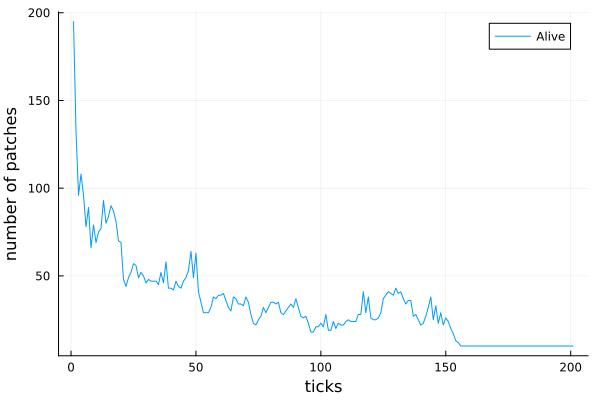

Row,Alive
,Int64
1,195
2,132
3,96
4,108
5,96
6,78
7,89
8,66
9,79


In [33]:
df = get_nums_patches(model, patch-> patch.is_alive, labels=["Alive"], 
    plot_result = true)

![png](assets/CGOL/CGOLPlot1.png)